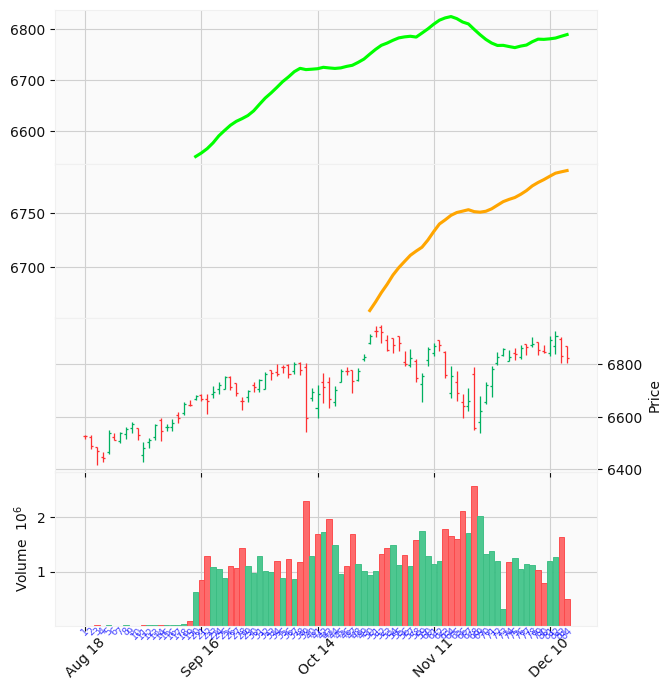

In [7]:
import yfinance as yf
import mplfinance as mpf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

csv_file = 'ES(495512563)(1 day)(4 M)_historical_data.csv'
df = pd.read_csv(csv_file, parse_dates=True)
df.columns = df.columns.str.lower()
df.index = pd.DatetimeIndex(df['date'])
df['tick_num'] = np.arange(1, len(df) + 1)

df['sam_20'] = df['close'].rolling(20).mean()
df['sam_50'] = df['close'].rolling(50).mean()

fig = mpf.figure(style='yahoo', figsize=(7,8))
ax4 = fig.add_subplot(4,1,4)
ax1 = fig.add_subplot(4,1,1, sharex=ax4)
ax2 = fig.add_subplot(4,1,2, sharex=ax4)
ax3 = fig.add_subplot(4,1,3, sharex=ax4)

ap0 = [
    mpf.make_addplot(df['sam_20'], color='#00FF00', panel=0, ax=ax1),
    mpf.make_addplot(df['sam_50'], color='#FFa500', panel=1, ax=ax2)
]

mpf.plot(df, ax=ax3, addplot=ap0, volume=ax4)
fig.subplots_adjust(hspace=0.05)
ax1.tick_params(labelbottom=False)
ax2.tick_params(labelbottom=False)
ax3.tick_params(labelbottom=False)

# SOLUTION: Add tick numbers at intervals
interval = 20
for idx, row in df.iterrows():
    tick = row['tick_num']
    ax4.text(tick-1, ax2.get_ylim()[0], f'{tick}', 
                 ha='center', va='top', fontsize=7, color='blue', 
                 rotation=45, alpha=0.7)

plt.show()